In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from lmapr1492 import get_plot_dos
from scipy.optimize import minimize
from scipy.integrate import quad

In [56]:
mp_key = "nbKtMcNjVctWQexVKEJTiT489Bo6oYrr"
mp_id = "mp-11869"

In [57]:
#Récupération de la structure
with MPRester(mp_key) as m:
    struct = m.get_structure_by_material_id(mp_id)
    ph_dos_struct = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
#Représentation de la densité d'états de phonons du matériau
fig_ph_dos = get_plot_dos(ph_dos_struct)
fig_ph_dos.show()

In [59]:
#Constante
N_at = len(struct) #Nombre d'atomes 
R = 8.314 #[J/molK]

#Extraction des données pour Cv
temp = np.array(np.arange(5, 1000, 5))
cv = np.array([ph_dos_struct.cv(temp[i])/ (3*N_at*R) for i in range(len(temp))])

## Température de Debye 

Pour calculer la température de Debye telles que les modèles correspondants minimisent l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique, on va d'abord calculer la chaleur spécifique selon le modèle de Debye qui fait l'hypothèse que toutes les fréquences $\omega_{\sigma}(q)$ ont la même dispersion linéraire, cela donne : $\frac{C_{v}}{3N_{at}R}=3(\frac{T}{\Theta_{D}})^3 \int_0^{\frac{\Theta_{D}}{T}} \frac{x^4e^x}{(e^x-1)^2}\,dx$ qu'on va comparer avec la chaleur spécifique des données pour obtenir l'erreur. La température de Debye va être obtenu en minimisant cette erreur grâce à la fonction scipy.optimize.minimize.

In [60]:
#Partie à intégrer pour avoir Cv selon Debye
def fct(x):
    return (x**4*np.exp(x))/((np.exp(x)-1)**2)

In [61]:
#Fonction pour avoir Cv selon Debye
def Debye(T, thetaD):
    return 3 * ((T/thetaD)**3) * quad(fct, 0, thetaD/T)[0]

In [62]:
#Calcule de l'erreur 
def debye_error(thetaD):
    return np.sum([(Debye(temp[i], thetaD) - cv[i])**2 for i in range(len(temp))])

In [63]:
thetaD_init = 150
best_thetaD = minimize(debye_error, thetaD_init).x[0]
print("La température de Debye vaut ",best_thetaD, "K")

La température de Debye vaut  270.3346557326057 K


## Température d'Einstein

On va suivre le même raisonnement que pour le modèle de Debye cependant la formule de la chaleur spécifique change étant donné que dans ce modèle on fait l'hypothèse que toutes les fréquences $\omega_{\sigma}(q)$ sont égales à un fréquence naturelle de vibration. La formule pour trouver Cv devient : $\frac{C_{v}}{3N_{at}R}=(\frac{\Theta_{E}}{T})^2\frac{e^{\Theta_E/T}}{(e^{\Theta_E/T}-1)^2}$.

In [64]:
#Fonction pour avoir Cv selon Einstein
def Einstein(T, thetaE):
    fract = thetaE/T
    return (fract**2) * (np.exp(fract)/(np.exp(fract)-1)**2)

In [65]:
#Calcule de l'erreur
def einstein_error(thetaE):
    cv_einstein = Einstein(temp, thetaE)
    return np.sum((cv-cv_einstein)**2)

In [66]:
thetaE_init = 150
best_thetaE = minimize(einstein_error, thetaE_init).x[0]
print("La température d'Einstein vaut ", best_thetaE, "K")

La température d'Einstein vaut  200.00935921054779 K


## Les 3 courbes de chaleur spécifique

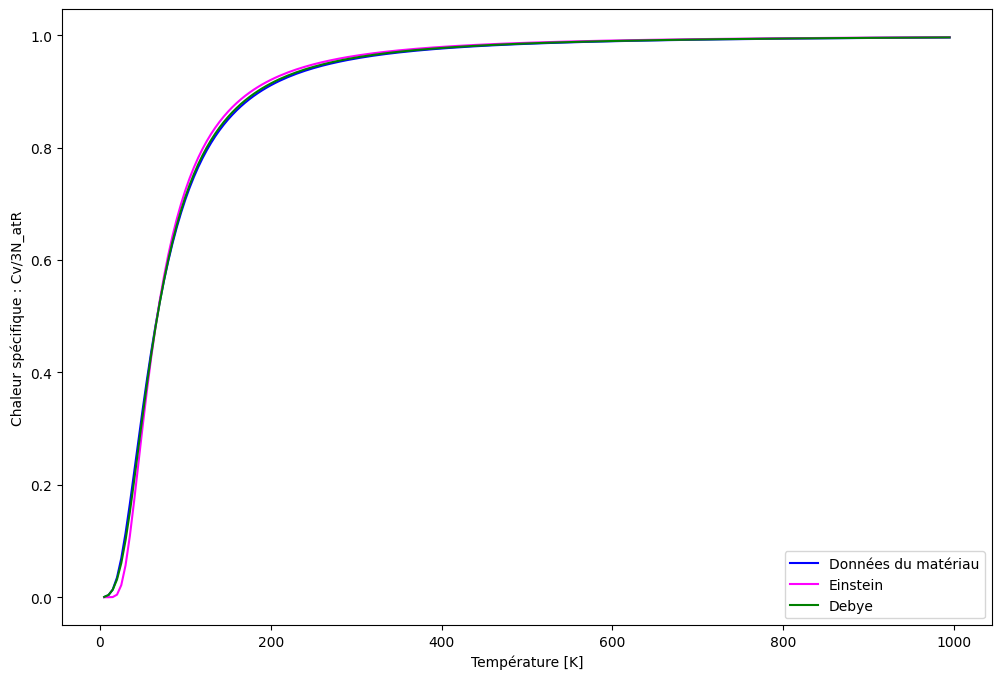

In [67]:
#Chaleur spécifique Einstein
cv_einstein = Einstein(temp, best_thetaE)

#Chaleur spécique Debye
cv_debye = [Debye(T, best_thetaD) for T in temp]

plt.figure(figsize=(12,8))
plt.plot(temp, cv, label='Données du matériau', color='blue')
plt.plot(temp, cv_einstein, label='Einstein', color='magenta')
plt.plot(temp, cv_debye, label='Debye', color='green')
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique : Cv/3N_atR')
plt.legend()
plt.show()

## Les 3 densités d'états de phonons correspondantes

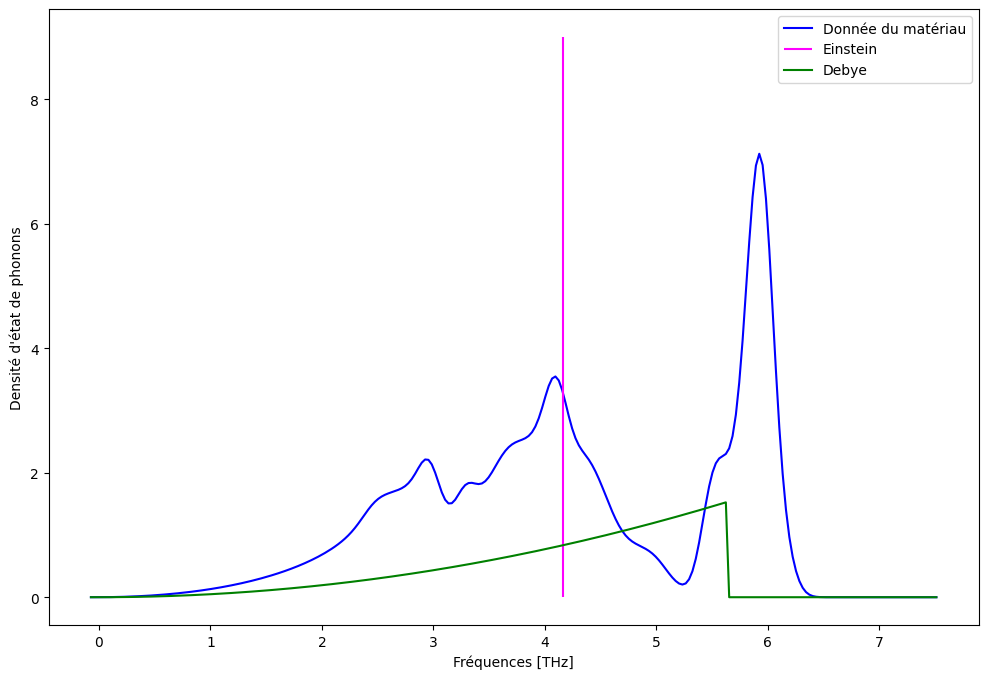

In [89]:
#Constante
kb = 1.38e-23 # cste de Boltzman[J/K]
hbar = 1.055e-34 # cste de Planck/2pi [Js]


omega_debye = 1e-12*(kb*best_thetaD)/hbar 
omega_einstein = 1e-12*(kb*best_thetaE)/hbar

#Densité d'état pour le modèle de Debye est nulle après la fréquence de Debye et est une fonction du second degré avant.
densité_debye = np.zeros(len(ph_dos_struct.frequencies))
for i,f in enumerate(ph_dos_struct.frequencies):
    omega = 2*np.pi*f
    if omega < omega_debye:
        densité_debye[i] = (9*N_at*(omega)**2)/(np.pi*(omega_debye**3))


plt.figure(figsize=(12,8))
#Densité d'état pour les données du matériau
plt.plot(ph_dos_struct.frequencies, ph_dos_struct.densities, color='blue', label='Donnée du matériau')
#La densité d'état pour le modèle d'einstein est simplement un delta de dirac : g_E(w) = 3N_at*delta(w-w_E)
plt.vlines(omega_einstein/(2*np.pi), 0, 3*N_at, color='magenta', label='Einstein')
plt.plot(ph_dos_struct.frequencies, densité_debye*2*np.pi, color='green', label='Debye')
plt.xlabel('Fréquences [THz]')
plt.ylabel("Densité d'état de phonons")
plt.legend()
plt.show()

Malheureusement le graphique ne correspond pas au résultat attendu car nous devrions avoir une courbe pour le modèle de Debye tel que l'aire sous cette courbe soit la même que celle sous la courbe exacte (celle des données du matériau). Or ici on voit bien que cette aire sera plus petite que celle sous la courbe exacte. Cette erreur doit être dû à la simplification que j'ai faite pour calculer g_D(w). Celle-ci est que j'ai posé $q_D = (\frac{6\pi}{\Omega})^{1/3}$ et dans la formule $g_D(\omega) = \frac{3 N_{at}\Omega}{2(\pi)^2} \frac{\omega^2}{v^3}$ j'ai remplacé v car $\omega_D = vq_D$. Ce qui m'a permis d'appliquer la formule simplifiée suivante : $$g_D(\omega) = \frac{9 N_{at}}{\pi} \frac{\omega^2}{\omega_D^3} $$